# **Importation**

In [1]:
import pandas as pd
import numpy as np
import optuna
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
train_df = pd.read_csv('./training_data.csv')
test_df = pd.read_csv('./testing_data.csv')


c:\Users\ASUS VIVOBOOK\envs\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **# Pre-prossessing**

In [2]:
# Fonction de feature engineering
def feature_engineering(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['year'] = df['timestamp'].dt.year
    df['month'] = df['timestamp'].dt.month
    df['day'] = df['timestamp'].dt.day
    df['hour'] = df['timestamp'].dt.hour
    df['minute'] = df['timestamp'].dt.minute
    df['second'] = df['timestamp'].dt.second
    df['log_cpu_usage'] = np.log1p(df['cpu_usage'])
    df['log_ram_usage'] = np.log1p(df['ram_usage'])
    df['cpu_ram_interaction'] = df['cpu_usage'] * df['ram_usage']
    df.drop('timestamp', axis=1, inplace=True)
    return df

# Convertir la limite de RAM en mégaoctets
def convert_ram_to_mb(ram_str):
    if 'G' in ram_str:
        return float(ram_str.replace('G', '')) * 1024
    elif 'M' in ram_str:
        return float(ram_str.replace('M', ''))
    else:
        return float(ram_str)

# Séparer les caractéristiques de 'cpu_type'
def separate_cpu_type(df):
    cpu_splits = df['cpu_type'].str.split(' ', expand=True)
    df['cpu_brand'] = cpu_splits[0]
    df['cpu_series'] = cpu_splits[1] + ' ' + cpu_splits[2]
    df['cpu_model'] = cpu_splits[3]
    df.drop('cpu_type', axis=1, inplace=True)
    return df

# Appliquer le feature engineering
train_df = feature_engineering(train_df)
test_df = feature_engineering(test_df)

# Appliquer la séparation du type de CPU
train_df = separate_cpu_type(train_df)
test_df = separate_cpu_type(test_df)

# Convertir la limite de RAM et l'utilisation de la RAM
train_df['ram_limit'] = train_df['ram_limit'].apply(convert_ram_to_mb)
test_df['ram_limit'] = test_df['ram_limit'].apply(convert_ram_to_mb)
train_df['ram_usage'] = train_df['ram_usage'] / (1024 * 1024)
test_df['ram_usage'] = test_df['ram_usage'] / (1024 * 1024)

# Appliquer le one-hot encoding sur les nouvelles colonnes CPU
train_df = pd.get_dummies(train_df, columns=['cpu_brand', 'cpu_series', 'cpu_model'])
test_df = pd.get_dummies(test_df, columns=['cpu_brand', 'cpu_series', 'cpu_model'])

# Aligner les colonnes de test_df avec celles de train_df
test_df = test_df.reindex(columns=train_df.columns, fill_value=0)



Visualiser la matrice de correlation

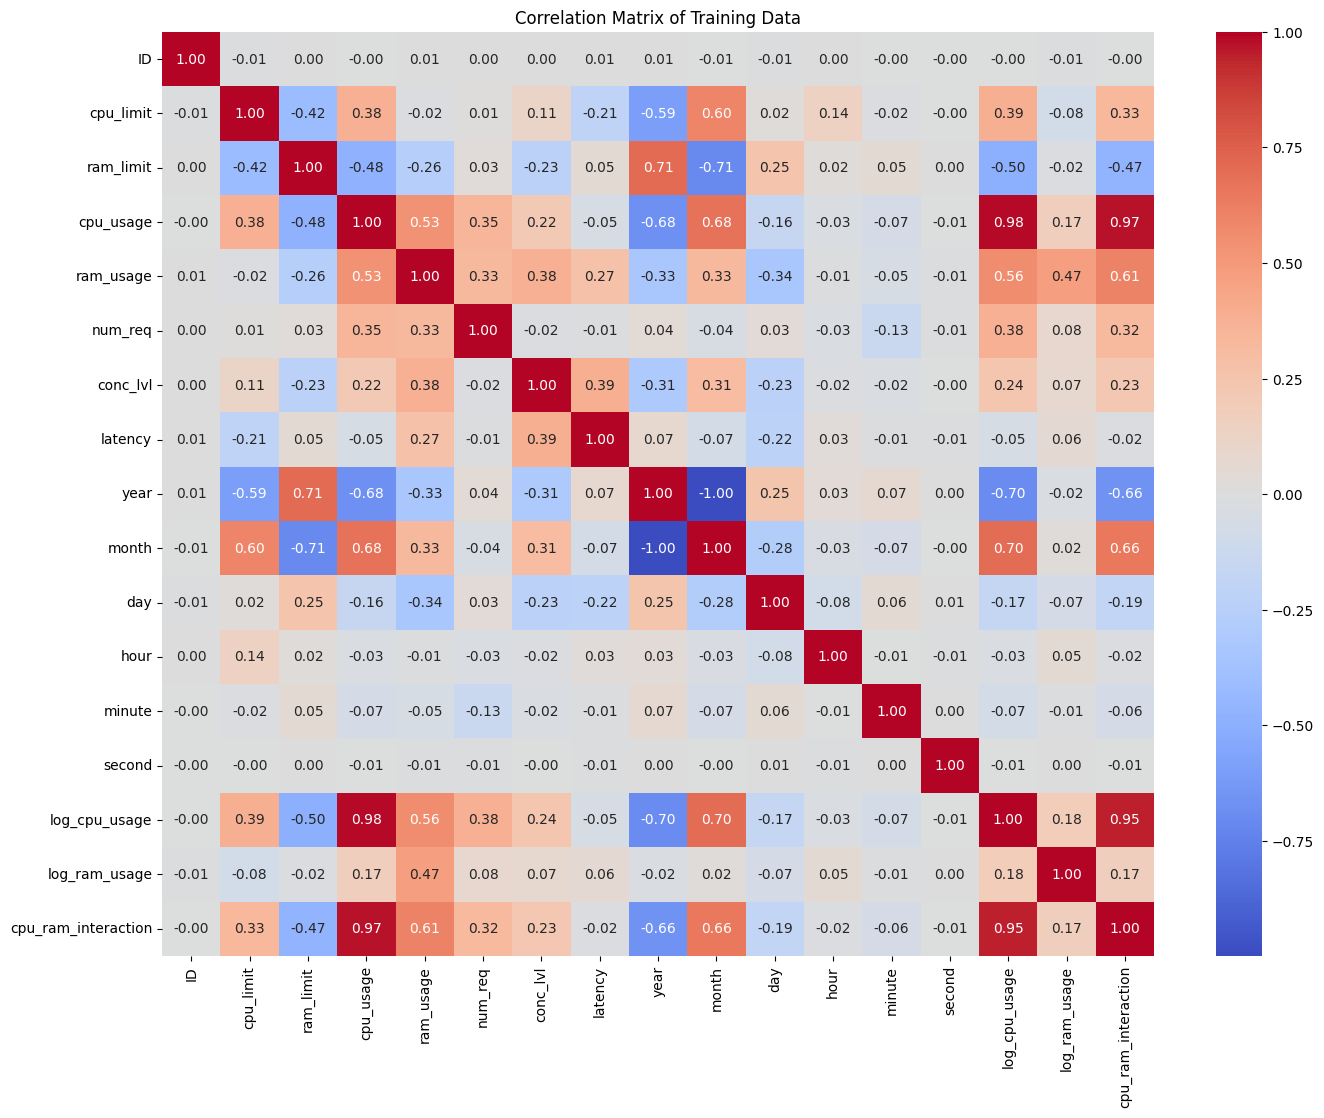

In [3]:
# Filter the DataFrame to only include numeric columns
numeric_df = train_df.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Training Data')
plt.show()

Prepare the features

In [4]:
# Define feature and target columns
target = 'latency'
features = train_df.columns.tolist()
features.remove('ID')
features.remove(target)

# Splitting the data into features and target
X = train_df[features]
y = train_df[target]
X_test = test_df[features]

# Pipelines

In [5]:

# Preprocessing pipelines
numerical_cols = X.select_dtypes(include=['number']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

numerical_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])


# Hyperparameter tuning with optuna

In [ ]:

# Define the objective function for Optuna
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 1, 255),
    }

    model = CatBoostRegressor(**params, verbose=0)
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    cv = TimeSeriesSplit(n_splits=5)
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='r2')
    return scores.mean()

# Optimize hyperparameters using Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Get the best parameters for CatBoost
best_cat_params = study.best_params
print("Best CatBoost parameters:", best_cat_params)


In [ ]:
!pip install pycaret

In [ ]:

from pycaret.regression import setup, compare_models
# Configuration de PyCaret
exp_reg = setup(data=df, target='Y', verbose=False)

# Comparaison des modèles et sélection du meilleur
best_model = compare_models()

# Affichage du meilleur modèle
print(best_model)

Best param

In [6]:
# Best parameters for CatBoost from Optuna
best_cat_params = {
    'iterations': 816,
    'depth': 8,
    'learning_rate': 0.07171708709814875,
    'random_strength': 0.11112346678000523,
    'bagging_temperature': 0.5777098777296865,
    'border_count': 201
}

# Prediction

In [8]:

# Define models with the best parameters
best_cat_model = CatBoostRegressor(**best_cat_params, verbose=0)
best_xgb_model = XGBRegressor(objective='reg:squarederror')

# Create the voting regressor
voting_regressor = VotingRegressor([
    ('cat', best_cat_model),
    ('xgb', best_xgb_model),
    ('rf', RandomForestRegressor(n_estimators=500)),
    ('gb', GradientBoostingRegressor(n_estimators=500))
])

# Create the pipeline with the voting regressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', voting_regressor)
])

# Fit the pipeline on the entire training data
pipeline.fit(X, y)

# Predict on the test set
predictions = pipeline.predict(X_test)


# submission file

In [9]:

# Create submission file
submission = pd.DataFrame({
    'ID': test_df['ID'],
    'latency': predictions
})
submission.to_csv('submissionVotingRegressorCln.csv', index=False)

print(submission.head())



      ID       latency
0   1182  1.068827e+08
1  19002  6.078724e+07
2  13933  2.142683e+07
3  10049  2.049958e+06
4  19412  7.678883e+06


# Validation

Simple validation

In [ ]:
from sklearn.model_selection import cross_val_score

# Calculate R2 score directly using cross_val_score
kf = KFold(n_splits=3, shuffle=False)
r2_scores = cross_val_score(pipeline, X, y, cv=kf, scoring='r2')

print("R2 scores:", r2_scores)
print("Mean R2 score:", np.mean(r2_scores))

Time Series

In [ ]:

# Validation
cv = TimeSeriesSplit(n_splits=5)
val_scores = []

for train_index, val_index in cv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.fit(X_train, y_train)
    val_predictions = pipeline.predict(X_val)
    val_r2 = r2_score(y_val, val_predictions)
    val_scores.append(val_r2)

print("Validation R2 scores:", val_scores)
print("Mean Validation R2 score:", np.mean(val_scores))

KFold

In [ ]:
from sklearn.model_selection import KFold

# Quicker validation using K-Fold cross-validation
kf = KFold(n_splits=3, shuffle=False)
val_scores = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.fit(X_train, y_train)
    val_predictions = pipeline.predict(X_val)
    val_r2 = r2_score(y_val, val_predictions)
    val_scores.append(val_r2)

print("Validation R2 scores:", val_scores)
print("Mean Validation R2 score:", np.mean(val_scores))
